# day note 2018-0303

## electrode tract

In [1]:
%matplotlib inline
import os     # for getting file paths
import neo    # for reading neural data (TDT format)
import dg2df  # for reading behavioral data
import pandas as pd
import re     # use regular expression to find file names
import numpy as np
import scipy as sp

import misc_tools
import signal_align
import data_load_DLSH
import matplotlib as mpl
import matplotlib.pyplot as plt
import df_ana
import PyNeuroAna as pna
import PyNeuroPlot as pnp
import data_load_DLSH
mpl.style.use('ggplot')


the data files to be loaded are: ['retract_from_21000']
loading TDT block: retract_from_21000


finish loading tdt blocks


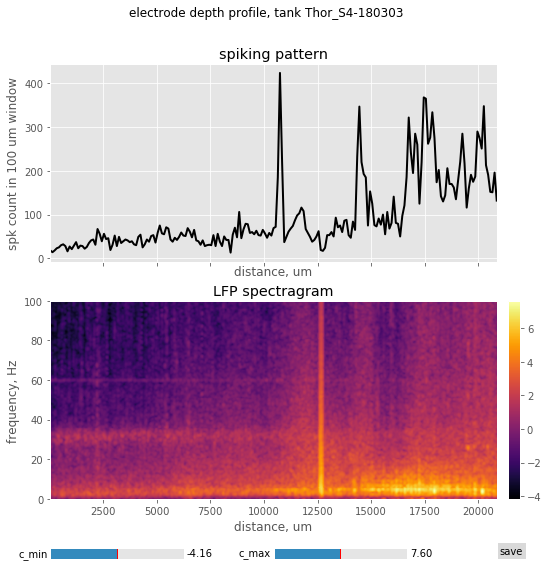

In [4]:
dir_tdt_tank = '/shared/lab/projects/encounter/data/TDT'
dir_dg = '/shared/lab/projects/analysis/shaobo/data_dg'
speed_retract = 10  # um/sec
binsize_dist = 100      # bin for distance
ch_index = 1
tf_reverse_dist = True
tf_spectragram = True
tf_spectragram_interactive = True
total_distance = None
range_ch=None
range_ch_pos_rel=None
t_gauss_sigma_spcg = 5
keyword_tank='Thor_S4-180303'
keyword_blk='retract'

path_save_fig = './temp_figs'

def load_blk(keyword_blk=keyword_blk, keyword_tank=keyword_tank, dir_tdt_tank=dir_tdt_tank,
             tf_verbose=True, tf_interactive=False, sortname=''):
    [name_tdt_blocks, path_tdt_tank] = \
        data_load_DLSH.get_file_name(keyword_blk, keyword_tank, mode='tdt',
                                     tf_interactive=tf_interactive, dir_tdt_tank=dir_tdt_tank)

    name_datafiles = name_tdt_blocks
    if True:
        print('')
        print('the data files to be loaded are: {}'.format(name_datafiles))

    """ ----- load neural data ----- """
    blk = neo.core.Block()  # block object containing multiple segments, each represents data form one file
    reader = neo.io.TdtIO(dirname=path_tdt_tank)  # reader for loading data
    for name_tdt_block in name_tdt_blocks:  # for every data file
        if tf_verbose:
            print('loading TDT block: {}'.format(name_tdt_block))
        seg = reader.read_segment(blockname=name_tdt_block,
                                  sortname=sortname)  # read one TDT file as a segment of block
        blk.segments.append(seg)  # append to blk object
    if tf_verbose:
        print('finish loading tdt blocks')

    blk = data_load_DLSH.standardize_blk(blk)
    return blk.segments[0]

def plot_electrode_depth_profile(keyword_blk=keyword_blk, keyword_tank=keyword_tank, dir_tdt_tank=dir_tdt_tank,
                                 ch_index = 1, range_ch= None,
                                 speed_retract=speed_retract, binsize_dist=binsize_dist, range_ch_pos_rel=None,
                                 tf_reverse_dist=tf_reverse_dist, total_distance=None, t_gauss_sigma_spcg = t_gauss_sigma_spcg,
                                 tf_spectragram=tf_spectragram, tf_spectragram_interactive=tf_spectragram_interactive):
    """ generate plot of depth profile of spiking pattern and lfp spectrogram

    assuming data is collected when electrode is retracted at a constant speed """

    """ ----- load data ----- """
    seg = load_blk(keyword_blk=keyword_blk, keyword_tank=keyword_tank, dir_tdt_tank=dir_tdt_tank)

    """ ----- use time and speed to infer depth ----- """
    t_range = np.array([seg.t_start, seg.t_stop])
    if total_distance is not None:
        t_range[1] = total_distance/speed_retract
    dist_range = t_range*speed_retract

    """ ----- get spiking pattern ----- """
    spk_time = np.sort(np.concatenate([np.array(spktrn.times) for spktrn in seg.spiketrains if spktrn.annotations['channel_index']==ch_index]))
    spk_dist = spk_time * speed_retract
    spk_bin, dist_bin_edge = np.histogram(spk_dist, np.arange(dist_range[0], dist_range[1], binsize_dist))
    dist_bin_center = (dist_bin_edge[:-1] + dist_bin_edge[1:]) / 2
    if range_ch is not None:
        list_spk_bin = []
        for ch_cur in range_ch:
            try:
                spk_time_cur = np.sort(np.concatenate([np.array(spktrn.times) for spktrn in seg.spiketrains if
                                               spktrn.annotations['channel_index'] == ch_cur]))
            except:
                spk_time_cur = np.array([])
            spk_dist_cur = spk_time_cur * speed_retract
            spk_bin_cur, _ = np.histogram(spk_dist_cur, np.arange(dist_range[0], dist_range[1], binsize_dist))
            list_spk_bin.append(spk_bin_cur)
        spk_bin_array = np.vstack(list_spk_bin)

    """ ----- compute spectrogram ----- """
    if tf_spectragram:
        scale_factor = 10**6
        lfp_sig = [anasig for anasig in seg.analogsignals if re.search('LFPs.*', anasig.name) and anasig.annotations['channel_index']==ch_index][0]
        lfp_trace = np.ravel(lfp_sig) * scale_factor
        lfp_fs = np.array(lfp_sig.sampling_rate)
        lfp_ts = range(len(lfp_trace))/lfp_fs + np.array(lfp_sig.t_start)
        if total_distance is not None:
            lfp_ts = lfp_ts[lfp_ts<t_range[1]]
            lfp_trace = lfp_trace[:len(lfp_ts)]
        spcg, spcg_t, spcg_f = pna.ComputeSpectrogram(data=np.expand_dims(lfp_trace, axis=0),
                               fs=lfp_fs, t_ini=lfp_ts[0], t_bin=1.0, t_step=1.0, t_axis=1, f_lim=[0,100])
        spcg = spcg[0,:,:]
        if t_gauss_sigma_spcg is not None:
            spcg = sp.ndimage.filters.gaussian_filter1d(spcg, sigma=t_gauss_sigma_spcg, axis=1)
        spcg_dist = spcg_t * speed_retract

    """ ----- direction of distance axis ----- """
    if tf_reverse_dist:   # top to bottom
        dist_bin = np.flip(dist_bin_center, axis=0)
        if tf_spectragram:
            dist_spcg = np.flip(spcg_dist, axis=0)
    else:                 # bottom to top
        dist_bin = dist_bin_center
        if tf_spectragram:
            dist_spcg = spcg_dist

    """ ----- plot ----- """
    if tf_spectragram:
        h_fig, h_ax = plt.subplots(2, 1, figsize=[8, 8], sharex=True, squeeze=False)
    else:
        h_fig, h_ax = plt.subplots(1, 1, figsize=[8, 4], sharex=True, squeeze=False)

    """ upper panel: spiking pattern """
    plt.axes(h_ax[0,0])
    if range_ch is not None:
        list_color = plt.cm.rainbow(np.linspace(0,1,len(range_ch)))
        for i, ch_cur in enumerate(range_ch):
            if range_ch_pos_rel is None:
                dist_shift = 0
            else:
                dist_shift = range_ch_pos_rel[i]
            plt.plot(dist_bin+dist_shift, spk_bin_array[i,:], color=list_color[i], linewidth=1, alpha=0.5)
    plt.plot(dist_bin, spk_bin, color='k', linewidth=2)
    plt.xlabel('distance, um')
    plt.ylabel('spk count in {} um window'.format(binsize_dist))
    plt.title('spiking pattern')

    """ lower panel: spectrogram """
    if tf_spectragram:
        plt.axes(h_ax[1,0])
        plt.pcolormesh(dist_spcg, spcg_f, np.log(spcg), cmap='inferno')
        plt.xlabel('distance, um')
        plt.ylabel('frequency, Hz')
        plt.title('LFP spectragram')

        """ colorbar """
        ax_loc = h_ax[1, 0].get_position()
        h_colorbar = plt.colorbar( cax = h_fig.add_axes([ax_loc.x1+0.02, ax_loc.y0, 0.02, ax_loc.y1-ax_loc.y0]))

        """ colorbar, interactive control widgets """
        if tf_spectragram_interactive:
            clim_org_min, clim_org_max = h_colorbar.get_clim()
            clim_range = clim_org_max - clim_org_min
            h_slider_clim_min = mpl.widgets.Slider(ax=h_fig.add_axes([ax_loc.x0, 0.02, (ax_loc.x1 - ax_loc.x0) * 0.3, 0.02]),
                                                  label='c_min', valmin=clim_org_min-0.5*clim_range, valmax=clim_org_min+0.5*clim_range, valinit=clim_org_min)
            h_slider_clim_max = mpl.widgets.Slider(ax=h_fig.add_axes([(ax_loc.x0+ax_loc.x1)*0.5, 0.02, (ax_loc.x1-ax_loc.x0)*0.3, 0.02]),
                                                  label='c_max', valmin=clim_org_max-0.5*clim_range, valmax=clim_org_max+0.5*clim_range, valinit=clim_org_max)
            def update_clim_min(val):
                plt.axes(h_ax[1,0])
                plt.clim(vmin=val)
            def update_clim_max(val):
                plt.axes(h_ax[1, 0])
                plt.clim(vmax=val)
            h_slider_clim_min.on_changed(update_clim_min)
            h_slider_clim_max.on_changed(update_clim_max)

            h_button_savefig = mpl.widgets.Button(ax=h_fig.add_axes([ax_loc.x1, 0.02, 0.05, 0.03]), label='save')
            def savefig(event):
                plt.savefig('{}/electrode_depth_profile_tank_{}.png'.format(path_save_fig, keyword_tank))
            h_button_savefig.on_clicked(savefig)
    h_ax[0,0].set_xlim([dist_bin.min(), dist_bin.max()])
    plt.suptitle('electrode depth profile, tank {}'.format(keyword_tank))

    """ return results """
    return_dict = {'spk': (dist_bin, spk_bin), 'spcg': None, 'slider': None}
    if tf_spectragram:
        return_dict['spcg'] = (dist_spcg, spcg_f, spcg)
    if tf_spectragram_interactive and tf_spectragram:    # to return the widegets object is important, otherwise widgets do not work whtin functions
        return_dict['widgets'] = (h_slider_clim_min, h_slider_clim_max, h_button_savefig)

    return return_dict

""" ----- process data day by day ----- """
temp = plot_electrode_depth_profile(keyword_tank='Thor_S4-180303', keyword_blk='retract', tf_spectragram=True)

## ERP by depth

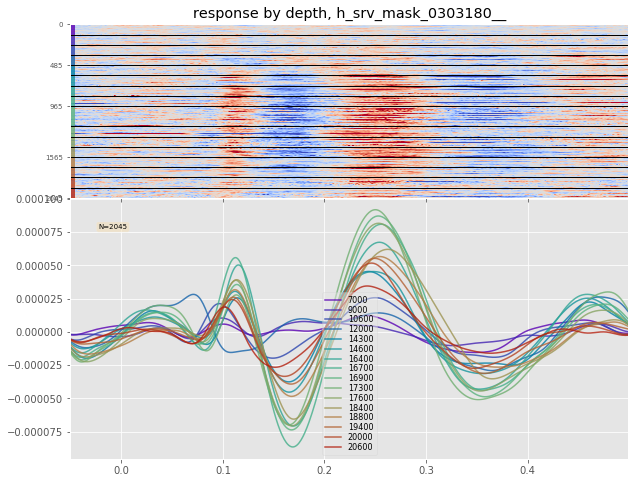

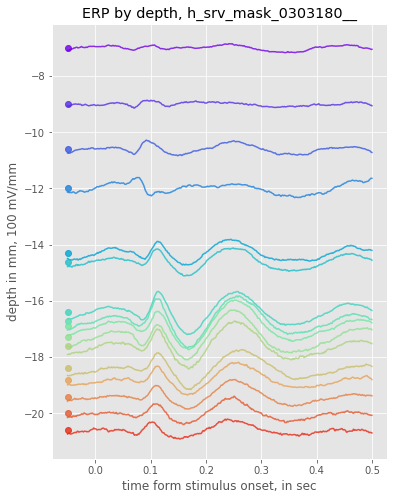

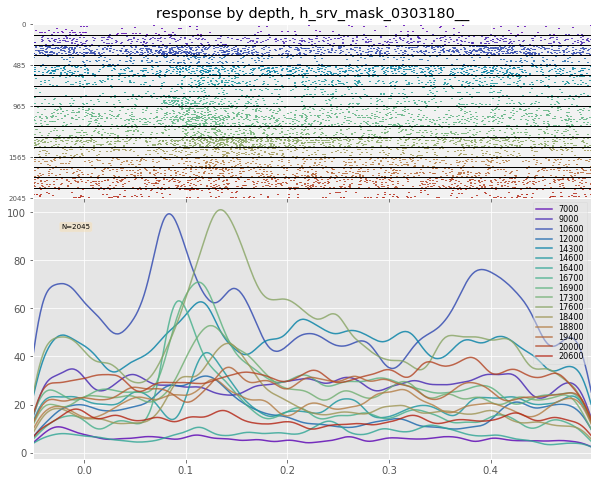

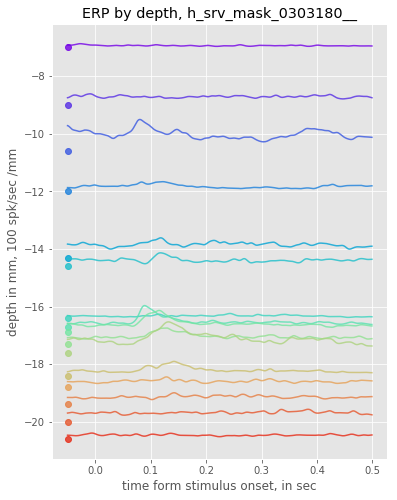

In [5]:
[blk, data_df, name_tdt_blocks] = data_load_DLSH.load_data(
    '.*srv', '.*Thor.*S4.*180303.*',
    dir_tdt_tank=dir_tdt_tank, dir_dg=dir_dg,
    tf_interactive=False, tf_verbose=False)

file_depth = {2:  7000, 3:  9000, 4: 10600,  5: 10600, 6: 10600,
              7: 12000, 8: 12000, 
              9: 14300, 10: 14600, 
              11: 16400, 12: 16400, 13: 16700, 14: 16900, 15: 16900, 
              16: 17300, 17: 17600, 18: 17600, 19: 17600, 20: 18400, 21: 18400, 22: 18400, 
              23: 18800, 24: 19400,  25: 20000, 26: 20600
              }

# signal = 'spk'
signal = 'spk'

def plot_response_by_depth(blk, data_df, name_tdt_blocks, signal):

    data_df['depth'] = [file_depth[file] for file in data_df['file']]
    
    
    filename_common = misc_tools.str_common(name_tdt_blocks)
    dir_temp_fig = './temp_figs'
    
    data_df = data_load_DLSH.standardize_data_df(data_df, filename_common)
    blk     = data_load_DLSH.standardize_blk(blk)
    
    ts_StimOn = data_load_DLSH.get_ts_align(blk, data_df, dg_tos_align='stimon')
    
    window_offset = [-0.05, 0.500]
    if signal == 'LFP':
        data_neuro=signal_align.blk_align_to_evt(blk, ts_StimOn, window_offset,
                                                 type_filter='ana.*', name_filter='LFP.*',
                                                 spike_bin_rate=1000, chan_filter=[1])
    elif signal == 'spk':
        data_neuro=signal_align.blk_align_to_evt(blk, ts_StimOn, window_offset,
                                                 type_filter='spiketrains*', name_filter='.*Code[1-9]$',
                                                 spike_bin_rate=1000)
    
    # combine different sortcodes
    data_neuro['data'][:,:,0] = np.sum(data_neuro['data'], axis=2)
    
    plt.figure(figsize=(10,8))
    pnp.PsthPlot(data_neuro['data'][:, :, 0], ts=data_neuro['ts'],
                 cdtn=data_df['depth'], limit=None, sk_std=0.010,
                 tf_legend=True, color_style='continuous')
    plt.title('response by depth, {}'.format(filename_common))
    
    # plot traces by depth
    data_neuro = signal_align.neuro_sort(data_df, grpby='depth', neuro=data_neuro)
    ERPs_by_depth = pna.GroupAve(data_neuro)
    
    colors = pnp.gen_distinct_colors(len(ERPs_by_depth), style='continuous')
    if signal == 'LFP':
        ERPs_by_depth = ERPs_by_depth*10**6
        scale = 100  # 10 uV/mm in axis
        scale_unit = 'mV/mm'
    elif signal == 'spk':
        ERPs_by_depth = pna.SmoothTrace(ERPs_by_depth, sk_std=0.005, ts=data_neuro['ts'])
        scale = 100  # 10 uV/mm in axis
        scale_unit = 'spk/sec /mm'
    
    plt.figure(figsize=[6,8])
    for i, cdtn in enumerate(data_neuro['cdtn']):
        plt.plot(data_neuro['ts'],  ERPs_by_depth[i,:,0]/scale - cdtn/1000.0, color=colors[i])
        plt.plot(data_neuro['ts'][0], -cdtn/1000.0, 'o', color=colors[i])
    plt.xlabel('time form stimulus onset, in sec')
    plt.ylabel('depth in mm, {} {}'.format(scale, scale_unit))
    plt.title('ERP by depth, {}'.format(filename_common))


plot_response_by_depth(blk, data_df, name_tdt_blocks, 'LFP')
plot_response_by_depth(blk, data_df, name_tdt_blocks, 'spk')

## Plot Response by File

['h_srv_mask_030318002', 'h_srv_mask_030318003', 'h_srv_mask_030318004', 'h_V4_spot_030318005', 'h_MT_mapping_030318006', 'h_srv_mask_030318007', 'h_MT_mapping_030318008', 'h_srv_mask_030318009', 'h_srv_mask_030318010', 'h_srv_mask_030318011', 'h_MT_mapping_030318012', 'h_srv_mask_030318013', 'h_srv_mask_030318014', 'h_srv_mask_030318015', 'h_srv_mask_030318016', 'h_srv_mask_030318017', 'h_V4_spot_030318018', 'h_MT_mapping_030318019', 'h_srv_mask_030318020', 'h_MT_mapping_030318021', 'h_V4_spot_030318022', 'h_srv_mask_030318023', 'h_srv_mask_030318024', 'h_srv_mask_030318025', 'h_srv_mask_030318026']


/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


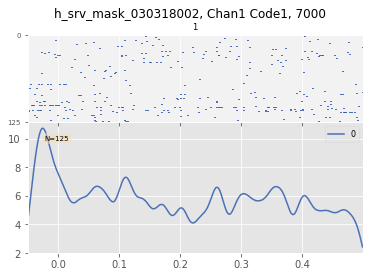

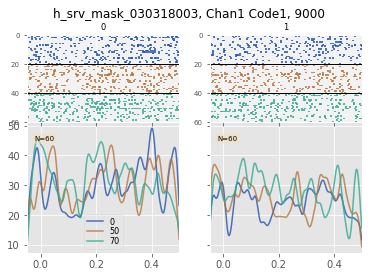

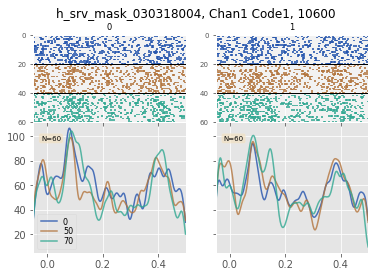

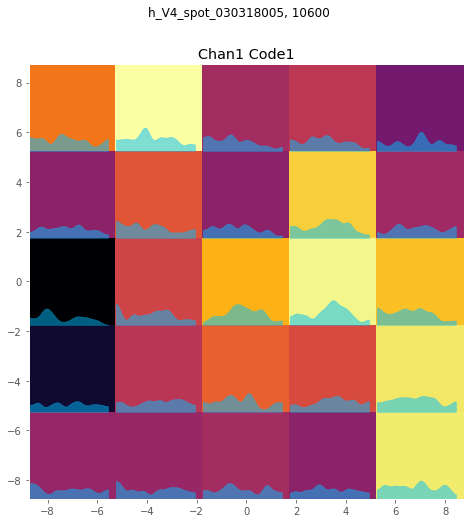

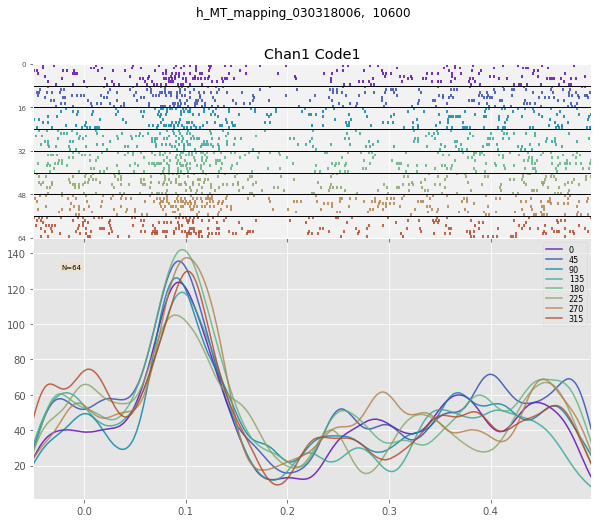

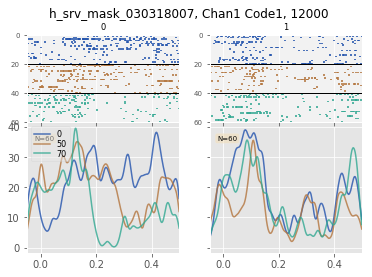

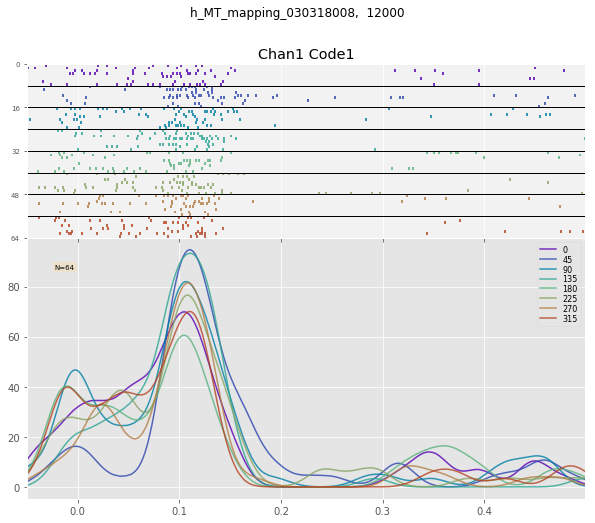

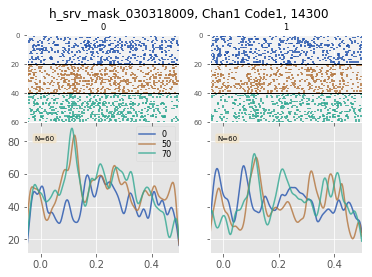

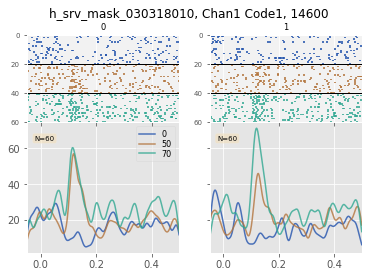

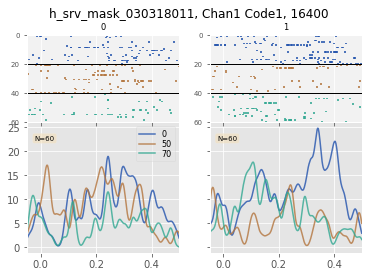

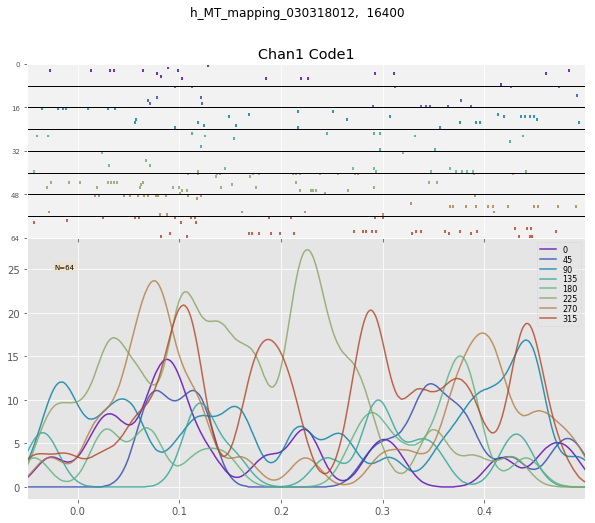

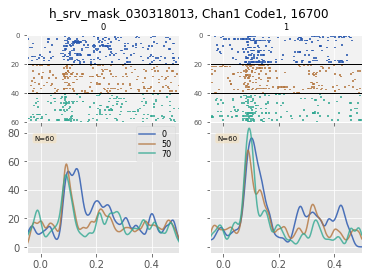

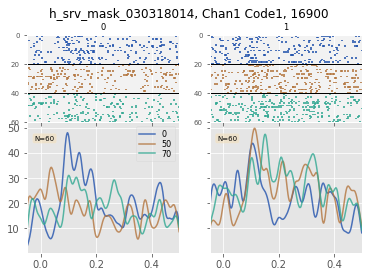

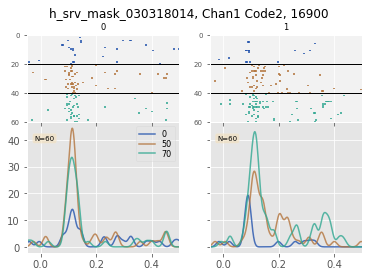

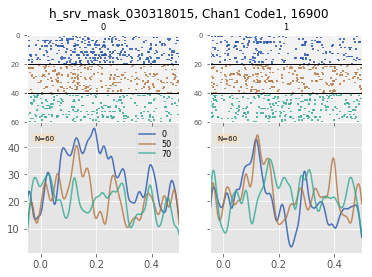

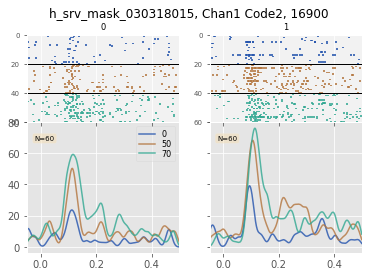

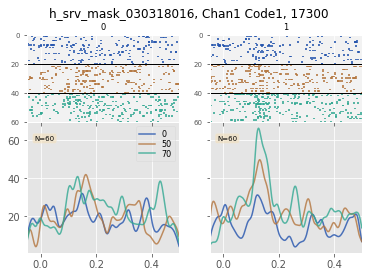

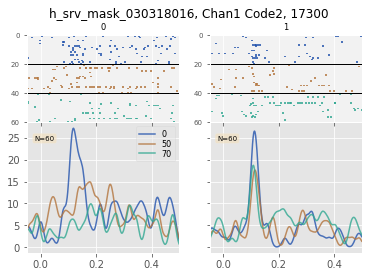

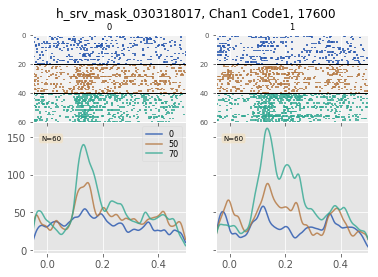

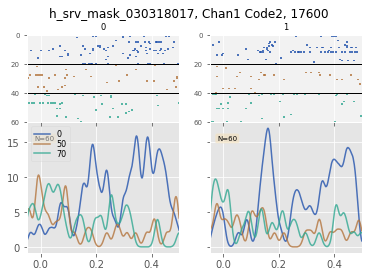

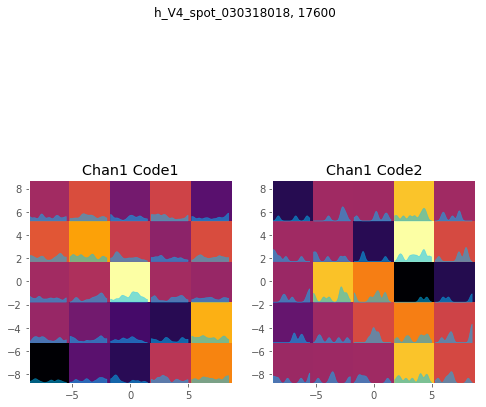

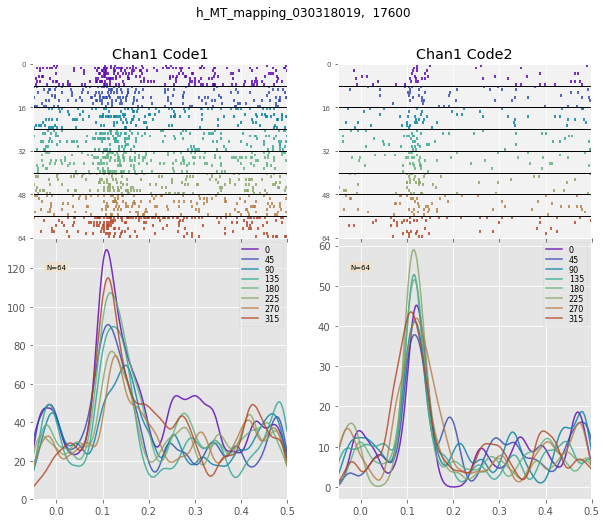

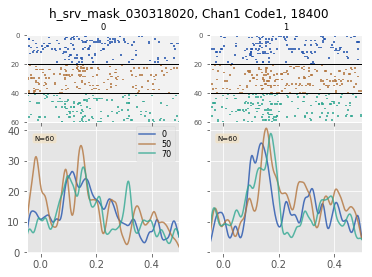

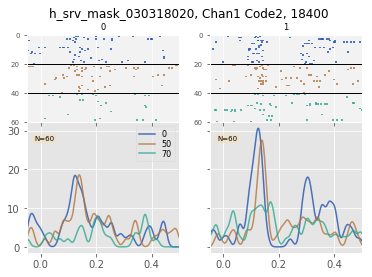

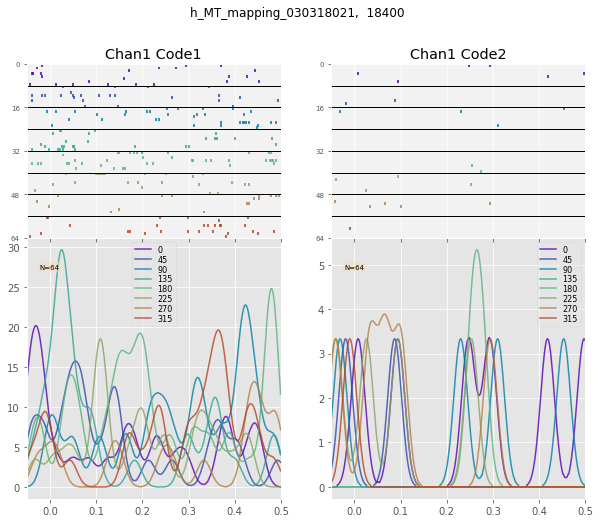

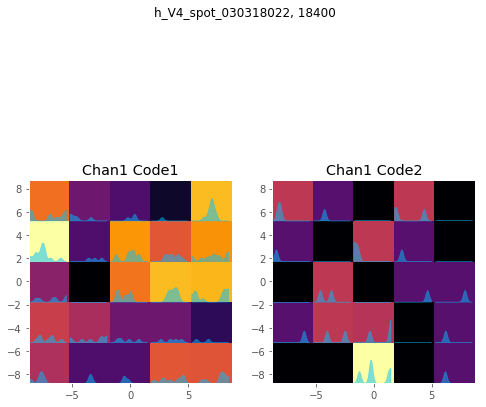

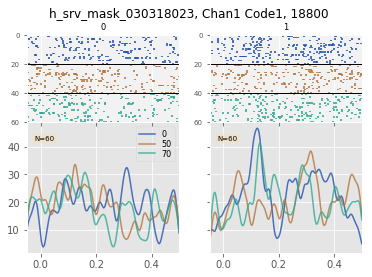

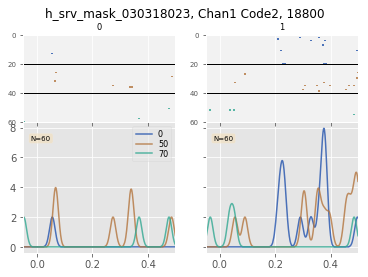

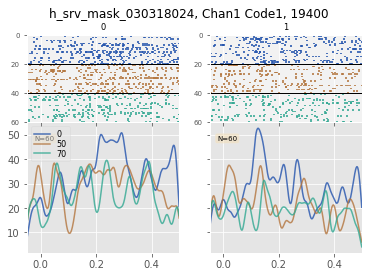

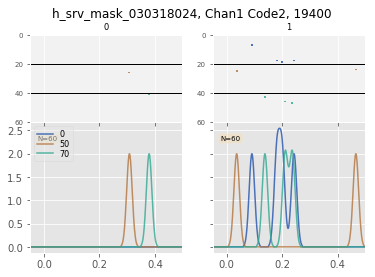

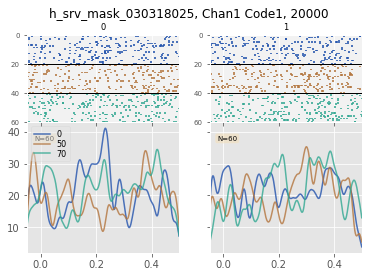

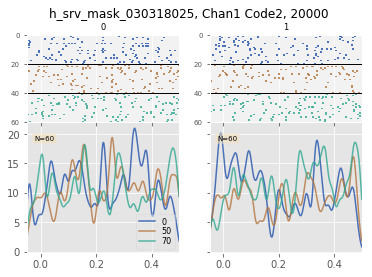

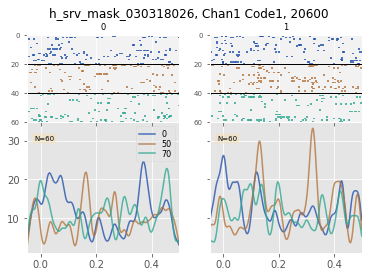

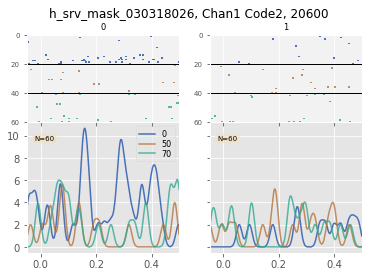

In [6]:
keyword_tank='Thor_S4-180303'
keyword_blk='.*h_.*'
name_tdt_blocks, _ = data_load_DLSH.get_file_name(keyword_tank=keyword_tank, keyword=keyword_blk, dir_tdt_tank=dir_tdt_tank, dir_dg=dir_dg)
name_tdt_blocks.sort(key=lambda name: name[-3:])
print(name_tdt_blocks)

file_depth = {2:  7000, 3:  9000, 4: 10600,  5: 10600, 6: 10600,
              7: 12000, 8: 12000, 
              9: 14300, 10: 14600, 
              11: 16400, 12: 16400, 13: 16700, 14: 16900, 15: 16900, 
              16: 17300, 17: 17600, 18: 17600, 19: 17600, 20: 18400, 21: 18400, 22: 18400, 
              23: 18800, 24: 19400,  25: 20000, 26: 20600
              }

# signal = 'spk'
signal = 'spk'

def plot_response_by_file(name_tdt_block, signal='spk'):
    
    try:
        depth_cur = file_depth[int(name_tdt_block[-3:])]
    except:
        depth_cur = 0
        pass
    
    if 'V4' in  name_tdt_block:
        type_file = 'RF_mapping'
    elif 'MT' in name_tdt_block:
        type_file = 'direction_mapping'
    elif 'mask' in name_tdt_block:
        type_file = 'srv_mask'
    else:
        type_file = 'else'
    
    [blk, data_df, name_tdt_blocks] = data_load_DLSH.load_data(
        name_tdt_block, keyword_tank,
        dir_tdt_tank=dir_tdt_tank, dir_dg=dir_dg,
        tf_interactive=False, tf_verbose=False)
    
    data_df['depth'] = [file_depth[file] for file in data_df['file']]
    
    filename_common = misc_tools.str_common(name_tdt_blocks)
    
    data_df = data_load_DLSH.standardize_data_df(data_df, filename_common)
    blk     = data_load_DLSH.standardize_blk(blk)
    
    ts_StimOn = data_load_DLSH.get_ts_align(blk, data_df, dg_tos_align='stimon')
    

    if type_file == 'RF_mapping':
        window_offset = [0.0, 0.2]
        data_neuro=signal_align.blk_align_to_evt(blk, ts_StimOn, window_offset,
                                                 type_filter='spiketrains.*', name_filter='.*Code[1-9]$',
                                                 spike_bin_rate=1000, chan_filter=range(1,32+1))
        data_neuro=signal_align.neuro_sort(data_df, ['stim_pos_x','stim_pos_y'], [], data_neuro)
        num_signals = len(data_neuro['signal_info'])
        h_fig, h_axes = pnp.SubplotsAutoRowCol(num_signals, figsize=[8,8])
        for i_signal in range(num_signals):
            plt.axes(h_axes[i_signal])
            pnp.RfPlot(data_neuro, sk_std=0.01, indx_sgnl=i_signal)
            signal_name = data_neuro['signal_info'][i_signal]['name']
            plt.axis('equal')
            plt.axis('square')
            plt.title('{}'.format(signal_name))
        plt.suptitle('{}, {}'.format(name_tdt_block, depth_cur))
            
    elif type_file == 'direction_mapping':
        
        window_offset = [-0.050, 0.500]
        
        if signal == 'LFP':
            data_neuro=signal_align.blk_align_to_evt(blk, ts_StimOn, window_offset, 
                                                     type_filter='ana.*', name_filter='LFP.*', chan_filter=[1], 
                                                     spike_bin_rate=1000)
        elif signal == 'spk':
            data_neuro=signal_align.blk_align_to_evt(blk, ts_StimOn, window_offset,
                                                 type_filter='spiketrains*', name_filter='.*Code[1-9]$', chan_filter=[1],
                                                 spike_bin_rate=1000)
    
        num_signals = len(data_neuro['signal_info'])
        h_fig, h_axes = pnp.SubplotsAutoRowCol(num_signals, figsize=(10, 8))
        for i_signal in range(num_signals):
            plt.axes(h_axes[i_signal])
            signal_name = data_neuro['signal_info'][i_signal]['name']
            pnp.PsthPlot(data_neuro['data'][:, :, i_signal], ts=data_neuro['ts'],
                         cdtn=data_df['rotationDirections'], limit=None, sk_std=0.015,
                         tf_legend=True, color_style='continuous')
            plt.title('{}'.format(signal_name))
        plt.suptitle('{},  {}'.format(name_tdt_block, depth_cur))
    
    elif type_file == 'srv_mask':
        
        window_offset = [-0.050, 0.500]
        
        if signal == 'LFP':
            data_neuro=signal_align.blk_align_to_evt(blk, ts_StimOn, window_offset, 
                                                     type_filter='ana.*', name_filter='LFP.*', chan_filter=[1], 
                                                     spike_bin_rate=1000)
        elif signal == 'spk':
            data_neuro=signal_align.blk_align_to_evt(blk, ts_StimOn, window_offset,
                                                 type_filter='spiketrains*', name_filter='.*Code[1-9]$', chan_filter=[1],
                                                 spike_bin_rate=1000)
        
        grpby = 'stim_familiarized'
        df_group = df_ana.DfGroupby(data_df, groupby=grpby, tf_aggregate=False)
        for i_signal in range(len(data_neuro['signal_info'])):
            signal_name = data_neuro['signal_info'][i_signal]['name']
            h_fig, h_axes = pnp.CreateSubplotFromGroupby(df_group['order'], tf_title=False)
            # plt.gcf().set_size_inches([10, 8])
            tf_legend = True
            for cdtn in df_group['idx']:
                plt.axes(h_axes[cdtn])
                pnp.PsthPlot(data_neuro['data'][:, :, i_signal], ts=data_neuro['ts'],
                             cdtn=data_df['mask_opacity_int'], limit=df_group['idx'][cdtn], sk_std=0.010,
                             tf_legend=tf_legend)
                tf_legend = False
                plt.title(cdtn, fontsize='small')
            plt.suptitle('{}, {}, {}'.format(filename_common, signal_name, depth_cur))
    
    else:            
        print('file {} can not be processed'.format(name_tdt_block))


for name_tdt_block in  name_tdt_blocks:
    plot_response_by_file(name_tdt_block)
